In [78]:
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
# from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import random
import shutil

In [79]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision,Recall

In [80]:
# from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# target = 256

# # inject noise but keep dark parts black
# def addNoise(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
#     ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)
# #     thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)  # Adjust parameters as needed
# #     mask=tresh==0
    

#     randStd = random.uniform(0, 10.0) # 15
#     gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
#     noisy_image = image + gaussian
#     image = np.clip(noisy_image, 0, 255).astype(np.uint8)

#     image = preprocess_input(image)
#     return image

In [81]:
import cv2
import numpy as np
import random

target=256

def addNoiseAdaptive(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
    # Use adaptive thresholding
    mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    randStd = random.uniform(0, 10.0)
    gaussian = np.random.normal(randStd * -1, randStd, (target, target, 3))
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    # Assuming preprocess_input is defined elsewhere
    image = preprocess_input(image)
    return image


In [82]:
# import cv2
# import numpy as np

# def addNoiseWithAdaptiveThresholding(image):
#     """Adds noise to an image while preserving dark parts using adaptive thresholding.

#     Args:
#         image: The input image as a NumPy array.

#     Returns:
#         The noisy image with preserved dark parts.
#     """

#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#     # Apply adaptive thresholding to create a mask
#     ret,mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)
# #     mask = thresh == 0  # Invert mask to preserve dark parts

#     # Generate Gaussian noise with random standard deviation
#     rand_std = random.uniform(0, 10.0)
#     gaussian = np.random.normal(-rand_std, rand_std, (target,target,3))

#     # Apply noise only within the mask region
# #     noisy_image = image.copy()
# #     noisy_image[mask] += gaussian[mask]
# #     noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
#     noisy_image = image + gaussian
#     image = np.clip(noisy_image, 0, 255).astype(np.uint8)

# #     image = preprocess_input(image)

#     # Preprocess the image (replace with your specific preprocessing function)
#     noisy_image = preprocess_input(noisy_image)

#     return noisy_image


In [83]:
dataPath='release-crop/release-crop/'


In [84]:

# combine two unique generators using noise injection
batchSize = 4
trainDataGen = ImageDataGenerator(preprocessing_function=addNoiseAdaptive, horizontal_flip=True,vertical_flip=True,rotation_range=0,brightness_range=(0.95, 1.05))
trainGen1 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)
trainGen2 = trainDataGen.flow_from_directory(batch_size = batchSize, shuffle=True,  class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=1)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size = 1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 5000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 540 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [85]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D

# simple model that uses mobilenet background
def getModel(image_size, num_classes):
    model_input = Input(shape=(image_size, image_size, 3))
    
    transfer =MobileNetV3Large(
        weights='imagenet', include_top=False, input_tensor=model_input
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=3, activation='swish', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.25)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = ModelCheckpoint(
    filepath='=newbest.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [86]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_8 (Rescaling)        (None, 256, 256, 3)  0           ['input_9[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 128, 128, 16  432         ['rescaling_8[0][0]']            
                                )                                                                 
                                                                                            

                                                                                                  
 expanded_conv_2/depthwise/Batc  (None, 64, 64, 72)  288         ['expanded_conv_2/depthwise[0][0]
 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_317 (ReLU)               (None, 64, 64, 72)   0           ['expanded_conv_2/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_2/project (Conv2  (None, 64, 64, 24)  1728        ['re_lu_317[0][0]']              
 D)                                                                                               
                                                                                                  
 expanded_

 hNorm (BatchNormalization)                                      ']                               
                                                                                                  
 re_lu_322 (ReLU)               (None, 32, 32, 120)  0           ['expanded_conv_4/depthwise/Batch
                                                                 Norm[0][0]']                     
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 120)   0           ['re_lu_322[0][0]']              
 /AvgPool (GlobalAveragePooling                                                                   
 2D)                                                                                              
                                                                                                  
 expanded_conv_4/squeeze_excite  (None, 1, 1, 32)    3872        ['expanded_conv_4/squeeze_excite/
 /Conv (Co

                                                                                                  
 expanded_conv_5/project (Conv2  (None, 32, 32, 40)  4800        ['expanded_conv_5/squeeze_excite/
 D)                                                              Mul[0][0]']                      
                                                                                                  
 expanded_conv_5/project/BatchN  (None, 32, 32, 40)  160         ['expanded_conv_5/project[0][0]']
 orm (BatchNormalization)                                                                         
                                                                                                  
 expanded_conv_5/Add (Add)      (None, 32, 32, 40)   0           ['expanded_conv_4/Add[0][0]',    
                                                                  'expanded_conv_5/project/BatchNo
                                                                 rm[0][0]']                       
          

 tf.__operators__.add_231 (TFOp  (None, 16, 16, 200)  0          ['expanded_conv_7/depthwise/Batch
 Lambda)                                                         Norm[0][0]']                     
                                                                                                  
 re_lu_330 (ReLU)               (None, 16, 16, 200)  0           ['tf.__operators__.add_231[0][0]'
                                                                 ]                                
                                                                                                  
 tf.math.multiply_231 (TFOpLamb  (None, 16, 16, 200)  0          ['re_lu_330[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_164 (Multiply)        (None, 16, 16, 200)  0           ['expanded_conv_7/depthwise/Batch
          

                                                                                                  
 tf.math.multiply_234 (TFOpLamb  (None, 16, 16, 184)  0          ['re_lu_333[0][0]']              
 da)                                                                                              
                                                                                                  
 multiply_167 (Multiply)        (None, 16, 16, 184)  0           ['expanded_conv_9/expand/BatchNor
                                                                 m[0][0]',                        
                                                                  'tf.math.multiply_234[0][0]']   
                                                                                                  
 expanded_conv_9/depthwise (Dep  (None, 16, 16, 184)  1656       ['multiply_167[0][0]']           
 thwiseConv2D)                                                                                    
          

In [87]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',AUC(),Precision(),Recall()])
history = model.fit(trainGen, steps_per_epoch = len(trainGen1),validation_data=valGen, validation_steps=len(valGen), epochs=20, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/20
1250/1250 [==============================] - 64s 47ms/step - loss: 97.1146 - binary_accuracy: 0.5504 - auc_3: 0.5610 - precision_3: 0.5467 - recall_3: 0.5643 - val_loss: 52.9710 - val_binary_accuracy: 0.6889 - val_auc_3: 0.7816 - val_precision_3: 0.7742 - val_recall_3: 0.5333 - lr: 1.0000e-04
Epoch 2/20
1250/1250 [==============================] - 58s 46ms/step - loss: 32.6669 - binary_accuracy: 0.6226 - auc_3: 0.6601 - precision_3: 0.6231 - recall_3: 0.6298 - val_loss: 15.6095 - val_binary_accuracy: 0.7704 - val_auc_3: 0.8593 - val_precision_3: 0.7852 - val_recall_3: 0.7444 - lr: 1.0000e-04
Epoch 3/20
1250/1250 [==============================] - 57s 46ms/step - loss: 8.3618 - binary_accuracy: 0.6626 - auc_3: 0.7280 - precision_3: 0.6655 - recall_3: 0.6694 - val_loss: 3.1146 - val_binary_accuracy: 0.7574 - val_auc_3: 0.8613 - val_precision_3: 0.8325 - val_recall_3: 0.6444 - lr: 1.0000e-04
Epoch 4/20
1250/1250 [==============================] - 58s 47ms/step - loss: 1.7955 - 

In [88]:
# model.load_weights('val-best.h5')

In [89]:
model.evaluate(testGen)

1000/1000 [==============================] - 12s 12ms/step - loss: 0.4344 - binary_accuracy: 0.9060 - auc_3: 0.9722 - precision_3: 0.9044 - recall_3: 0.9080


[0.4344005882740021,
 0.906000018119812,
 0.9722141027450562,
 0.9043824672698975,
 0.9079999923706055]

In [90]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [91]:
y_pred = model.predict(valGen, steps=len(valGen))

540/540 [==============================] - 7s 11ms/step


In [92]:
fpr, tpr, thresholds = roc_curve(valGen.classes, y_pred)
roc_auc = auc(fpr, tpr)

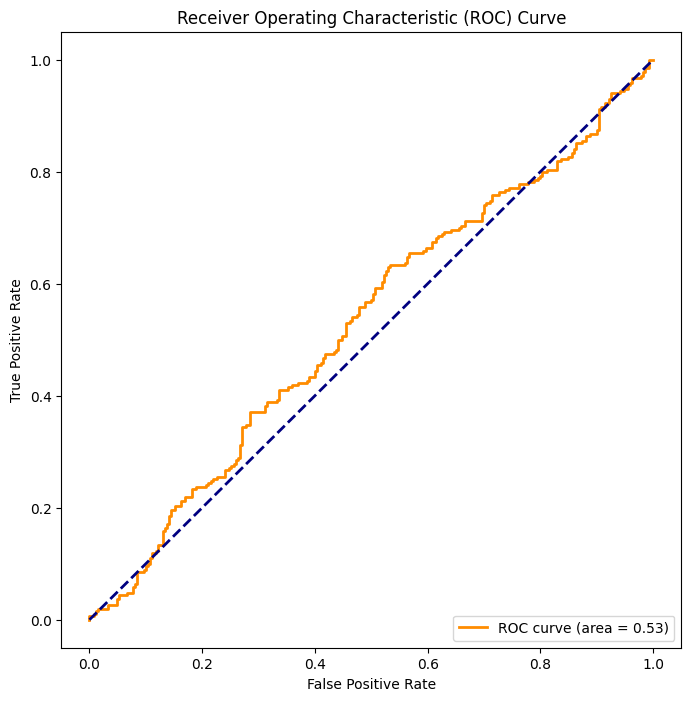

In [93]:
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [94]:
# from tensorflow.keras.models import load_model

In [95]:
# model.load_weights('val-best.h5')

In [96]:
# model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy',AUC(curve='ROC'),Precision(),Recall()])
#

In [97]:
# model.evaluate(testGen)

In [98]:
# from sklearn.metrics import roc_curve, auc

In [99]:
# Evaluate the model on the test set
# results = model.evaluate(testGen)

# # Extract relevant metrics
# test_loss = results[0]
# test_accuracy = results[1]
# test_auc = results[2]  # Assuming AUC is the third metric in the list

# # Print the test metrics
# print(f'Test Loss: {test_loss:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')
# print(f'Test ROC AUC: {test_auc:.4f}')

# # Plot ROC curve
# y_pred = model.predict(testGen)
# # Assuming your test set is binary classification, modify accordingly for multi-class
# # Adjust threshold for binary classification
# y_pred_binary = (y_pred > 0.90).astype(int)
# fpr, tpr, _ = roc_curve(testGen.labels, y_pred_binary)

# plt.figure(figsize=(10, 6))
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve on Test Set')
# plt.legend(loc='lower right')
# plt.show()